# Predicting stock price moves with Logistic Regression

## Imports & Settings

In [1]:
from pathlib import Path
import sys, os
from time import time
import warnings
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [4]:
YEAR = 252

## Load Data

In [5]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

### Select Investment Universe

In [6]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [7]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Logistic Regression

### Define cross-validation parameters

In [8]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [9]:
target = f'target_{lookahead}d'

In [10]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

1    56486
0    53189
Name: label, dtype: int64

In [11]:
Cs = np.logspace(-5, 5, 11)

In [12]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [13]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	  0.3 | 010 |  -0.27% |  50.44%
	  0.5 | 020 |   1.96% |  51.88%
	  0.7 | 030 |   2.83% |  52.01%
	  0.9 | 040 |   3.26% |  51.98%
	  1.0 | 050 |   3.95% |  52.44%
	  1.3 | 060 |   3.95% |  52.27%
	  1.5 | 070 |   4.75% |  52.61%
0.0001
	  0.2 | 010 |  -0.01% |  50.64%
	  0.4 | 020 |   2.33% |  52.07%
	  0.6 | 030 |   3.24% |  52.28%
	  0.9 | 040 |   3.36% |  52.10%
	  1.2 | 050 |   4.04% |  52.54%
	  1.4 | 060 |   4.04% |  52.34%
	  1.7 | 070 |   4.88% |  52.70%
0.001
	  0.2 | 010 |   0.47% |  50.98%
	  0.5 | 020 |   2.59% |  52.18%
	  0.7 | 030 |   3.65% |  52.51%
	  1.0 | 040 |   3.21% |  52.10%
	  1.3 | 050 |   3.87% |  52.52%
	  1.6 | 060 |   4.08% |  52.37%
	  1.9 | 070 |   4.96% |  52.75%
0.01
	  0.3 | 010 |   0.76% |  51.17%
	  0.6 | 020 |   2.46% |  52.02%
	  0.9 | 030 |   3.71% |  52.45%
	  1.2 | 040 |   3.17% |  51.98%
	  1.5 | 050 |   3.96% |  52.48%
	  1.8 | 060 |   4.21% |  52.34%
	  2.1 | 070 |   4.98% |  52.69%
0.1
	  0.3 | 010 |   0.76% |  51.16%
	  0.6 | 020 | 

In [14]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data.h5', 'logistic/predictions')

In [15]:
log_scores = pd.read_hdf('data.h5', 'logistic/scores')

In [16]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [17]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524515,0.036223,0.432348,0.499503,0.519326,0.545393,0.625747
0.00010,75.0,0.525371,0.035686,0.443016,0.501464,0.521408,0.544810,0.635552
0.00100,75.0,0.525975,0.036229,0.443691,0.500607,0.520732,0.543895,0.641003
0.01000,75.0,0.525557,0.036730,0.436580,0.500352,0.523543,0.550820,0.641920
0.10000,75.0,0.524027,0.036194,0.427517,0.500040,0.523716,0.549531,0.621818
1.00000,75.0,0.523636,0.036112,0.425671,0.498871,0.522696,0.549284,0.616500
10.00000,75.0,0.523585,0.036099,0.425372,0.498906,0.522492,0.549242,0.615857
100.00000,75.0,0.523580,0.036099,0.425377,0.498897,0.522496,0.549250,0.615853
1000.00000,75.0,0.523579,0.036100,0.425367,0.498893,0.522484,0.549263,0.615840


In [18]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300) 

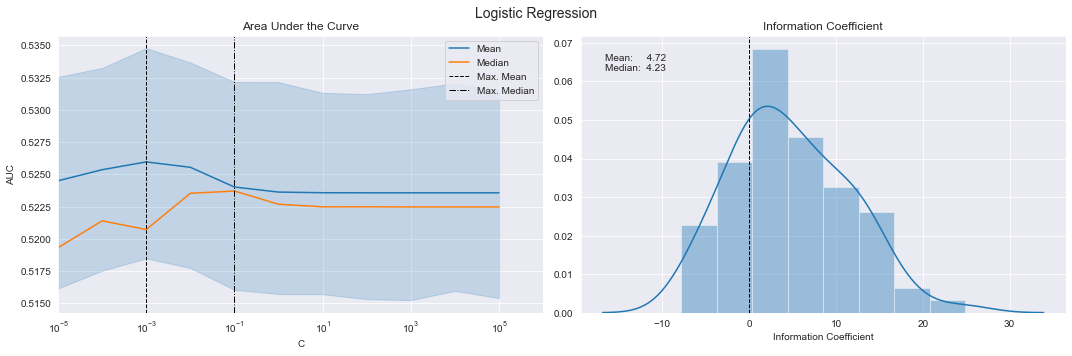

In [19]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/log_results', dpi=300);